In [2]:
import mnist
import torch
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as skld

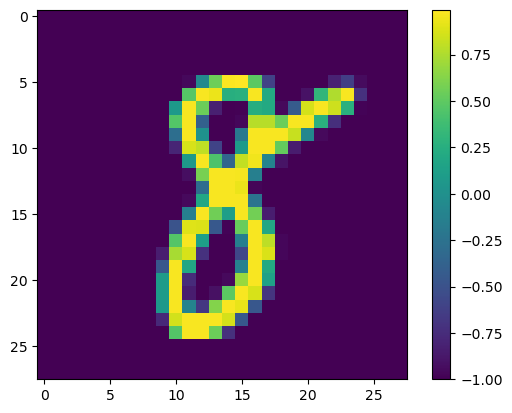

In [3]:
TRAIN = mnist.train_images()
def sample_mnist(N):
    idx = np.random.choice(np.arange(len(TRAIN)), N)
    X = 2*(TRAIN[idx]/256-0.5)
    return torch.FloatTensor(X)
plt.imshow(sample_mnist(10)[0])
plt.colorbar()
plt.show()

torch.Size([123, 1])


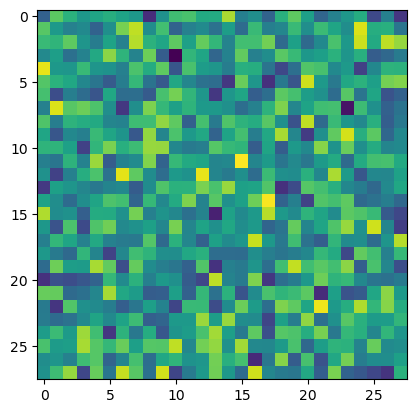

In [4]:
data_dim = 28*28
noise_dim = 128

make_gener = lambda: torch.nn.Sequential(
    torch.nn.Linear(noise_dim,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,data_dim),
    torch.nn.Tanh(),
    torch.nn.Unflatten(-1,(28,28))
)
make_discr = lambda: torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(data_dim,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1),
    torch.nn.Sigmoid()
)

print(make_discr()(torch.randn(123,28,28)).shape)
plt.imshow(make_gener()(torch.randn(123,128))[0].detach())
plt.show()

In [5]:
def make_real_and_fake(N, generator_model):
    real = sample_mnist(N)
    fake = generator_model(torch.randn(N,noise_dim))
    X = torch.cat([real,fake])
    y = torch.cat([torch.ones(N,1), torch.zeros(N,1)])
    return X,y

In [6]:
def train_discriminator(Nbatch, opt, generator, discriminator):
    opt.zero_grad()
    X,y  = make_real_and_fake(Nbatch, generator)
    pred = discriminator(X)
    loss = torch.nn.functional.binary_cross_entropy(pred,y)
    loss.backward()
    opt.step()  
    return loss

In [7]:
def train_generator(Nbatch, opt, generator, discriminator):
    opt.zero_grad()
    X,y  = make_real_and_fake(Nbatch, generator)
    pred_fake = discriminator(X[y[:,0]==0])
    loss = -torch.log(pred_fake).mean()
    loss.backward()
    opt.step()
    return loss

In [8]:
def plot_gan(model,losses):
    losses = np.array(losses)
    model.eval()
    f,axarr = plt.subplots(1,5)
    with torch.no_grad():
        generations = model(torch.randn(2,noise_dim)).detach()
    reals = sample_mnist(2)
    axarr[0].imshow(generations[0], vmin = -0.5, vmax = 0.5)
    axarr[1].imshow(generations[1], vmin = -0.5, vmax = 0.5)
    axarr[2].imshow(reals[0], vmin = -0.5, vmax = 0.5)
    axarr[3].plot(losses[:,0])
    axarr[4].plot(losses[:,1])
    plt.gcf().set_size_inches(10,2)
    #f.set_tight_layout(True)

i=0:


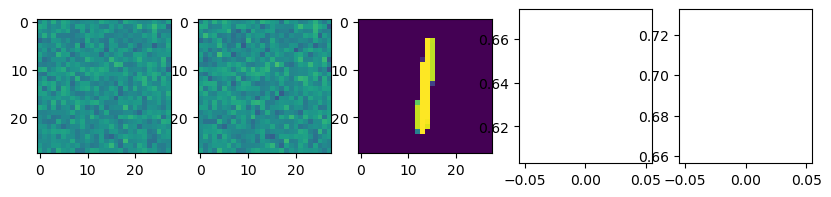

KeyboardInterrupt: 

In [11]:
def train():
    discriminator = make_discr()
    generator = make_gener()
    opt_d = torch.optim.Adam(discriminator.parameters(), 1e-4)
    opt_g = torch.optim.Adam(generator.parameters(), 1e-4)
    losses = []
    Nbatch = 100
    for i in range(200001):
        loss_g = train_generator(Nbatch, opt_g, generator, discriminator)
        loss_d = train_discriminator(Nbatch, opt_d, generator, discriminator)
        losses.append([float(loss_g), float(loss_d)])
        if i % 10000 == 0:
            print(f"i={i}:")
            plot_gan(generator,losses)
            plt.show()
    return generator

model = train()